# Conrady and ACF Dispersion Fit Validation

This notebook imports the refractive index database from Schott and validates the accuracy of two dispersion models:

- **Three-line Conrady fit:** Uses three classic Fraunhofer lines to fit the Conrady equation.
$$ n(\lambda) = A + B/\lambda + C/\lambda^{3.5}$$
- **Seven-line ACF fit:** Uses seven wavelengths to fit a Conrady-like ACF model.
$$ n(\lambda) = A + B/\lambda^{x_1} + C/\lambda^{x_2} + D\lambda^{x_3} $$

The results include accuracy metrics and parameter tables for a selection of common optical glasses.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit, OptimizeWarning
from typing import Dict

import sys
sys.path.append(str(Path('..').resolve() / 'src'))
from achromatcfw.data.glass_map.schott_glass import glass_sellmeier

import warnings
from IPython.display import display

In [2]:
def get_project_root() -> Path:
    return Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parent

root      = get_project_root()
xls_file  = root / "references" / "schott-optical-glass.xlsx"
df        = (pd.read_excel(xls_file, sheet_name="Preferred glasses", engine="openpyxl")
               .rename(columns=str.strip))
df["Glass"] = df["Glass"].str.strip()

# ── wavelength dictionary  |  *visible only* (400‑700 nm) ────────────────
wl_map = {
    # violet
    'nh'     : 404.657,
    'ng'     : 435.835,
    # blue
    "nF'"    : 479.990,
    'nF'     : 486.130,
    # green / yellow
    'ne'     : 546.070,
    'nd'     : 587.560,
    'nD'     : 589.290,
    # orange / red
    'n632.8' : 632.800,
    "nC'"    : 643.846,
    'nC'     : 656.272,
    'nr'     : 706.520,
    # near‑IR
    'ns'     : 852.113,
    'nt'     : 1013.98,
    'n1060.0': 1060.00
}


# ── column lists actually present in the catalogue ───────────────────────
wl_cols     = [c for c in wl_map if c in df.columns]
wl_cols_visible  = [col for col in wl_cols               # 400 ≤ λ ≤ 700 nm
                if 400 <= wl_map[col] <= 700]

print("Columns found: ", wl_cols_visible)

# ── glass selections ─────────────────────────────────────────────────────
all_glasses = df["Glass"].unique().tolist()

common_glasses = [
    "N-BK7", "N-BK10", "N-FK5",
    "N-BAK2", "N-BAK4", "N-LAK22", "N-LAK33B",
    "N-KZFS4", "N-KZFS5",
    "N-SF6", "N-SF10", "N-SF11",
    "N-LASF9", "N-BAF10", "N-LAF21",
    "F2", "N-F2", "SF10", "SF11"
]

# keep only those that actually exist in the sheet
common_glasses = [g for g in common_glasses if g in all_glasses]

if len(common_glasses) < 10:
    print("Preferred list incomplete – falling back to first 10 catalogue entries.")
    common_glasses = all_glasses[:10]

print("common_glasses:", common_glasses)

Columns found:  ['nh', 'ng', "nF'", 'nF', 'ne', 'nd', 'nD', 'n632.8', "nC'", 'nC']
common_glasses: ['N-BK7', 'N-BK10', 'N-FK5', 'N-BAK2', 'N-BAK4', 'N-LAK22', 'N-LAK33B', 'N-KZFS4', 'N-KZFS5', 'N-SF6', 'N-SF10', 'N-SF11', 'N-LASF9', 'N-BAF10', 'N-LAF21', 'F2', 'N-F2', 'SF10', 'SF11']


In [7]:
def conrady(lam_nm, A, B, C):
    lam_nm = np.asarray(lam_nm, float)
    return A + B/lam_nm + C/lam_nm**3.5

def fit_conrady(lam_nm, n, initial=(1.5, 1e3, 1e8)):
    lam_nm, n = map(np.asarray, (lam_nm, n))
    if len(lam_nm) == 3:                      # analytical 3‑point solution
        M = np.column_stack([np.ones_like(lam_nm), 1/lam_nm, 1/lam_nm**3.5])
        return np.linalg.solve(M, n)          # A, B, C
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=OptimizeWarning)
        popt, _ = curve_fit(conrady, lam_nm, n, p0=initial, maxfev=10000)
    return popt                               # A, B, C

def acf(lam_nm, a, b, c, d, x1, x2, x3):
    lam_nm = np.asarray(lam_nm, float)
    return 1 + a + b / lam_nm**x1 + c / lam_nm**x2 + d * lam_nm**x3

def fit_acf(lam_nm, n,
            initial=(0.0, 1e7, 1e12, 1e-12, 2, 4, 2),
            bounds=((-np.inf,     0,     0, -np.inf,   1.9999999, 3.99999999, 1.9999999),
                    ( np.inf,  1e10,  1e15,  np.inf,   2.0000001, 4.00000001, 2.0000001))):
    """Least‑squares fit of all 7 ACF parameters."""
    lam_nm, n = map(np.asarray, (lam_nm, n))
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=OptimizeWarning)
        popt, _ = curve_fit(acf, lam_nm, n, p0=initial,
                            bounds=bounds, maxfev=40000)
    return popt   # a, b, c, d, x1, x2, x3

def rmse(y, yhat): return np.sqrt(np.mean((np.asarray(y) - np.asarray(yhat))**2))

In [4]:
# ── 1 · Define columns & wavelengths used for each purpose ───────────────
fit_cols   = ["nF", "nd", "nC"]                    # three classic lines
fit_lambda = [wl_map[c] for c in fit_cols]         # → [486.13, 587.56, 656.272]

eval_cols  = wl_cols_visible                           # all visible‑band columns
eval_lambda = [wl_map[c] for c in eval_cols]

print("   λ used for 3‑param fit:", [wl_map[c] for c in fit_cols])
print("   λ used for RMS eval  :", [wl_map[c] for c in eval_cols])

# ── 2 · Run the fits & build the table ───────────────────────────────────
results_conrady = []

for glass in common_glasses:
    row = df.loc[df["Glass"] == glass].iloc[0]

    lam_all = np.array(eval_lambda, float)
    n_all   = np.array([row[c] for c in eval_cols], float)

    # --- 3‑line fit -------------------------------------------------------
    n_fdc = row[fit_cols].to_numpy(float)
    A3, B3, C3 = fit_conrady(fit_lambda, n_fdc)

    # --- full least‑squares fit ------------------------------------------
    Af, Bf, Cf = fit_conrady(lam_all, n_all)

    n_pred_3   = conrady(lam_all, A3, B3, C3)
    n_pred_all = conrady(lam_all, Af, Bf, Cf)

    results_conrady.append(dict(
        Glass=glass,
        num_lines=len(lam_all),
        pts_3_RMS = rmse(n_all, n_pred_3),
        pts_3_max = np.max(np.abs(n_all - n_pred_3)),
        full_RMS  = rmse(n_all, n_pred_all),
        full_max  = np.max(np.abs(n_all - n_pred_all)),
        A=A3, B=B3, C=C3
    ))

# --- 3 · Display with 1‑based counter ------------------------------------
summary_conrady = pd.DataFrame(results_conrady).sort_values("Glass").reset_index(drop=True)
summary_conrady.insert(0, "#", summary_conrady.index + 1)

styled = (summary_conrady[["#", "Glass", "A", "B", "C",
                   "num_lines", "pts_3_RMS", "pts_3_max",
                   "full_RMS", "full_max"]]
          .style.format({
              "A":"{:+.3e}", "B":"{:+.3e}", "C":"{:+.3e}",
              "pts_3_RMS":"{:.1e}", "pts_3_max":"{:.1e}",
              "full_RMS":"{:.1e}", "full_max":"{:.1e}"
          }))

display(styled)

   λ used for 3‑param fit: [486.13, 587.56, 656.272]
   λ used for RMS eval  : [404.657, 435.835, 479.99, 486.13, 546.07, 587.56, 589.29, 632.8, 643.846, 656.272]


,#,Glass,A,B,C,num_lines,pts_3_RMS,pts_3_max,full_RMS,full_max
0,1,F2,+1.586e+00,+1.583e+01,+3.353e+07,10,2.7e-05,8.5e-05,7.0e-06,1.5e-05
1,2,N-BAF10,+1.640e+00,+1.488e+01,+2.447e+07,10,2.1e-05,6.3e-05,4.4e-06,7.8e-06
2,3,N-BAK2,+1.519e+00,+1.059e+01,+1.321e+07,10,2.7e-05,8.2e-05,6.1e-06,1.0e-05
3,4,N-BAK4,+1.546e+00,+1.166e+01,+1.537e+07,10,1.9e-05,5.9e-05,5.5e-06,1.2e-05
4,5,N-BK10,+1.480e+00,+9.582e+00,+9.077e+06,10,5.2e-06,1.5e-05,2.3e-06,3.8e-06
5,6,N-BK7,+1.497e+00,+1.011e+01,+1.040e+07,10,8.5e-06,2.3e-05,2.5e-06,5.9e-06
6,7,N-F2,+1.587e+00,+1.554e+01,+3.402e+07,10,8.6e-05,2.6e-04,2.0e-05,3.8e-05
7,8,N-FK5,+1.471e+00,+8.930e+00,+8.406e+06,10,5.8e-06,1.6e-05,2.6e-06,5.8e-06
8,9,N-KZFS4,+1.583e+00,+1.493e+01,+2.267e+07,10,3.7e-06,9.7e-06,1.9e-06,4.1e-06
9,10,N-KZFS5,+1.620e+00,+1.665e+01,+2.961e+07,10,2.0e-05,6.0e-05,4.9e-06,8.4e-06


In [8]:
# ── 7 fixed wavelengths covering 404‑1060 nm ─────────────────────────────
fit_cols   = ["nh", "ng", "nF", "ne", "nC", "ns", "n1060.0"]
fit_lambda = [wl_map[c] for c in fit_cols]

# columns available in catalogue for 400‑1100 nm evaluation
wl_cols_eval = [c for c in wl_map if c in df.columns and 400 <= wl_map[c] <= 1100]

print("   λ used for 7‑param fit:", dict(zip(fit_cols, fit_lambda)))
print("   λ used for RMS eval  :", [wl_map[c] for c in wl_cols_eval])

# ── perform the ACF fits --------------------------------------------------
results_acf = []

for glass in common_glasses:
    row = df.loc[df["Glass"] == glass].iloc[0]

    # --- 7‑point fit set --------------------------------------------------
    if row[fit_cols].isna().any():
        missing = list(row[fit_cols][row[fit_cols].isna()].index)
        print(f"Skipping {glass}: missing {missing} data.")
        continue

    lam_fit = np.array(fit_lambda, float)
    n_fit   = row[fit_cols].to_numpy(float)

    # --- evaluation set (all 400‑1100 nm lines present) ------------------
    lam_eval = np.array([wl_map[c] for c in wl_cols_eval if not np.isnan(row[c])], float)
    n_eval   = np.array([row[c]    for c in wl_cols_eval if not np.isnan(row[c])], float)

    # fit 7 parameters
    a, b, c, d, x1, x2, x3 = fit_acf(lam_fit, n_fit)
    n_pred = acf(lam_eval, a, b, c, d, x1, x2, x3)

    results_acf.append(dict(
        Glass=glass,
        a=a, b=b, c=c, d=d, x1=x1, x2=x2, x3=x3,
        num_lines=len(lam_eval),
        ACF_RMS = rmse(n_eval, n_pred),
        ACF_max = np.max(np.abs(n_eval - n_pred))
    ))

# ── table with 1‑based counter ------------------------------------------
summary_acf = pd.DataFrame(results_acf).sort_values("Glass").reset_index(drop=True)
summary_acf.insert(0, "#", summary_acf.index + 1)

styled = (summary_acf[["#", "Glass", "a", "b", "c", "d",
                       "x1", "x2", "x3",
                       "num_lines", "ACF_RMS", "ACF_max"]]
          .style.format({
              "a":"{:+.3e}", "b":"{:+.3e}", "c":"{:+.3e}", "d":"{:+.3e}",
              "x1":"{:.3f}", "x2":"{:.3f}", "x3":"{:.3f}",
              "ACF_RMS":"{:.2e}", "ACF_max":"{:.2e}"
          }))

display(styled)

   λ used for 7‑param fit: {'nh': 404.657, 'ng': 435.835, 'nF': 486.13, 'ne': 546.07, 'nC': 656.272, 'ns': 852.113, 'n1060.0': 1060.0}
   λ used for RMS eval  : [404.657, 435.835, 479.99, 486.13, 546.07, 587.56, 589.29, 632.8, 643.846, 656.272, 706.52, 852.113, 1013.98, 1060.0]


,#,Glass,a,b,c,d,x1,x2,x3,num_lines,ACF_RMS,ACF_max
0,1,F2,+5.994e-01,+6.636e+03,+3.016e+08,-3.227e-09,2.000,4.000,2.000,14,2.20e-05,3.35e-05
1,2,N-BAF10,+6.524e-01,+5.987e+03,+1.706e+08,-3.432e-09,2.000,4.000,2.000,14,9.47e-06,1.46e-05
2,3,N-BAK2,+5.287e-01,+4.041e+03,+6.249e+07,-2.808e-09,2.000,4.000,2.000,14,2.66e-06,4.71e-06
3,4,N-BAK4,+5.562e-01,+4.468e+03,+8.390e+07,-3.010e-09,2.000,4.000,2.000,14,4.36e-06,7.20e-06
4,5,N-BK10,+4.891e-01,+3.294e+03,+3.897e+07,-3.401e-09,2.000,4.000,2.000,14,2.97e-06,5.48e-06
5,6,N-BK7,+5.072e-01,+3.565e+03,+4.810e+07,-3.324e-09,2.000,4.000,2.000,14,2.80e-06,5.62e-06
6,7,N-F2,+6.005e-01,+6.221e+03,+3.496e+08,-4.134e-09,2.000,4.000,2.000,14,3.03e-05,4.99e-05
7,8,N-FK5,+4.795e-01,+3.054e+03,+3.647e+07,-3.257e-09,2.000,4.000,2.000,14,2.33e-06,5.67e-06
8,9,N-KZFS4,+5.968e-01,+5.735e+03,+1.630e+08,-4.135e-09,2.000,4.000,2.000,14,8.42e-06,1.32e-05
9,10,N-KZFS5,+6.343e-01,+6.611e+03,+2.455e+08,-4.116e-09,2.000,4.000,2.000,14,1.72e-05,2.75e-05


## Mathematical Models Used in the Notebook — Thin‑Lens Context  

All wavelengths $\lambda$ are expressed in **nanometres (nm)**.

---

### 1 Reference Sellmeier Equation  

The catalog lists three coefficient pairs $(B_i,C_i)$ with $C_i$ in $\mu\text{m}^2$.  
Converted to nm$^2$:

$$
n_{\mathrm{Sell}}^{2}(\lambda)=
1+\sum_{i=1}^{3}\frac{B_i\,\lambda^{2}}{\lambda^{2}-C_i^{(\mathrm{nm})}},
\qquad
C_i^{(\mathrm{nm})}=C_i^{(\mu\text{m})}\times10^{6}.
$$

$$
n_{\mathrm{Sell}}(\lambda)=\sqrt{\,n_{\mathrm{Sell}}^{2}(\lambda)}.
$$  

---

### 2 Conrady 3‑Term Model  

$$
n_{\mathrm{Con}}(\lambda)=
A+\frac{B}{\lambda}+\frac{C}{\lambda^{3.5}}.
$$  

---

### 3 “Simplified ACF” 4‑Term Model  

Fixed exponents $(x_1,x_2,x_3)=(3.1,7.0,0.3)$:

$$
n_{\mathrm{ACF}}(\lambda)=
1+a+\frac{b}{\lambda^{x_1}}+\frac{c}{\lambda^{x_2}}+d\,\lambda^{x_3}.
$$  

---

### 4 Residual Metrics  

For any fitted model $n_\ast(\lambda)$

$$
\Delta n(\lambda)=n_\ast(\lambda)-n_{\mathrm{Sell}}(\lambda).
$$  

Sampled at $N$ wavelengths $\{\lambda_k\}$:

$$
\mathrm{RMS}=
\sqrt{\frac{1}{N}\sum_{k=1}^{N}\!\bigl[\Delta n(\lambda_k)\bigr]^2},
\qquad
\mathrm{Max}=\max_k\lvert\Delta n(\lambda_k)\rvert.
$$  

In [11]:
EXP1, EXP2, EXP3 = 2, 4, 2

conrady_params = (
    summary_conrady.set_index("Glass")[["A", "B", "C"]].to_dict("index")
)

# ─────────────────────────────────────────────────────────────────────────
# 1 · Dense‑grid residuals (unchanged)
# ─────────────────────────────────────────────────────────────────────────

def compute_deltas(glass: str,
                   lam_min: int = 400,
                   lam_max: int = 1000,
                   n_pts: int = 2001) -> Dict[str, float]:
    """Return residual statistics + arrays for ACF & Conrady vs Sellmeier."""

    # — coefficients -----------------------------------------------------
    row = summary_acf.loc[summary_acf["Glass"] == glass]
    if row.empty:
        raise ValueError(f"Glass '{glass}' not found in summary_acf.")
    row = row.iloc[0]
    a, b, c, d = row["a"], row["b"], row["c"], row["d"]

    if glass not in conrady_params:
        raise ValueError(f"Conrady parameters unavailable for '{glass}'.")
    A, B, C = conrady_params[glass].values()

    p = glass_sellmeier.get(glass)
    if p is None:
        raise ValueError(f"Sellmeier data missing for '{glass}'.")

    # — wavelength grid --------------------------------------------------
    lam_nm = np.linspace(lam_min, lam_max, n_pts)
    lam_sq = lam_nm ** 2

    # — Sellmeier (nm) ---------------------------------------------------
    c1_nm2, c2_nm2, c3_nm2 = p["c1"] * 1e6, p["c2"] * 1e6, p["c3"] * 1e6
    n2_sell = 1 + (
        p["b1"] * lam_sq / (lam_sq - c1_nm2) +
        p["b2"] * lam_sq / (lam_sq - c2_nm2) +
        p["b3"] * lam_sq / (lam_sq - c3_nm2)
    )
    n_sell = np.sqrt(n2_sell)

    # — models -----------------------------------------------------------
    n_acf = 1 + a + b / lam_nm**EXP1 + c / lam_nm**EXP2 + d * lam_nm**EXP3
    n_con = conrady(lam_nm, A, B, C)

    # — residuals --------------------------------------------------------
    res_acf = n_acf - n_sell
    res_con = n_con - n_sell

    def stats(res):
        return {
            "rms":     np.sqrt(np.mean(res**2)),
            "max_abs": np.max(np.abs(res)),
            "p95":     np.percentile(np.abs(res), 95),
        }

    return {
        "ACF":      stats(res_acf),
        "Conrady":  stats(res_con),
        "λ_nm":     lam_nm,
        "res_A":    res_acf,
        "res_C":    res_con,
        "n_Sell":   n_sell,
    }

# ─────────────────────────────────────────────────────────────────────────
# 2 · Quantify *lens* impact: Δf & Δf/f
# ─────────────────────────────────────────────────────────────────────────

def quantify_lens_impact(glass: str,
                         R1_mm: float,
                         R2_mm: float,
                         lam_min: int = 400,
                         lam_max: int = 1000,
                         n_pts: int = 2001) -> Dict[str, Dict[str, float]]:
    """Convert Δn to focal‑length error for a thin lens (air, same radii)."""

    delta = compute_deltas(glass, lam_min, lam_max, n_pts)
    lam_nm = delta["λ_nm"]
    n_sell = delta["n_Sell"]

    # Lensmaker denominator (air on both sides)
    K = (1 / R1_mm) - (1 / R2_mm)
    if K == 0:
        raise ValueError("Radii produce infinite focal length (R1 == R2).")

    f_sell = 1 / ((n_sell - 1) * K)   # array of focal lengths vs λ

    impact = {}
    for tag, res in {"ACF": delta["res_A"], "Conrady": delta["res_C"]}.items():
        df = -f_sell * res / (n_sell - 1)  # Δf array
        impact[tag] = {
            "Δf_RMS_mm":  np.sqrt(np.mean(df**2)),
            "Δf_Max_mm":  np.max(np.abs(df)),
            "(Δf/f)_RMS": np.sqrt(np.mean((df / f_sell)**2)),
            "(Δf/f)_Max": np.max(np.abs(df / f_sell)),
        }
    return impact

# ─────────────────────────────────────────────────────────────────────────
# 3 · Visual helper: curves, residuals, *and* focal‑shift stats
# ─────────────────────────────────────────────────────────────────────────

def plot_models(glass: str = "N-BK7",
                R1_mm: float = 50.0,
                R2_mm: float = -50.0,
                lam_min: int = 400,
                lam_max: int = 1000,
                n_pts: int = 601):
    """Plot dispersion curves + residuals and print focal‑shift metrics."""

    delta   = compute_deltas(glass, lam_min, lam_max, n_pts=2001)
    impact  = quantify_lens_impact(glass, R1_mm, R2_mm, lam_min, lam_max, n_pts=2001)

    lam_nm  = delta["λ_nm"]
    n_sell  = delta["n_Sell"]

    # Reconstruct model curves quickly ----------------------------------
    row = summary_acf.loc[summary_acf["Glass"] == glass].iloc[0]
    a, b, c, d = row["a"], row["b"], row["c"], row["d"]
    A, B, C = conrady_params[glass].values()
    n_acf = 1 + a + b / lam_nm**EXP1 + c / lam_nm**EXP2 + d * lam_nm**EXP3
    n_con = conrady(lam_nm, A, B, C)

    # Plot 1: absolute n curves -----------------------------------------
    plt.figure(figsize=(6, 4))
    plt.plot(lam_nm, n_sell, label="Sellmeier (reference)")
    plt.plot(lam_nm, n_acf, linestyle="--", label="ACF model")
    plt.plot(lam_nm, n_con, linestyle=":", label="Conrady model")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Refractive index n")
    plt.title(f"{glass}: Dispersion models vs Sellmeier")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # Plot 2: residuals (µRIU) ------------------------------------------
    plt.figure(figsize=(6, 4))
    plt.plot(lam_nm, delta["res_A"] * 1e6, linestyle="--", label="ACF − Sellmeier")
    plt.plot(lam_nm, delta["res_C"] * 1e6, linestyle=":", label="Conrady − Sellmeier")
    plt.axhline(0, color="black", linewidth=0.8)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Δn  (µRIU)")
    plt.title(f"{glass}: Residuals")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # Print focal‑shift impact ------------------------------------------
    print(f"Lens radii: R1 = {R1_mm} mm, R2 = {R2_mm} mm")
    print(f"Focal‑shift impact for {glass} (λ ∈ [{lam_min},{lam_max}] nm):")
    for model, vals in impact.items():
        print(f"  {model:<8}  RMS Δf = {vals['Δf_RMS_mm']*1e3:.2f} µm  (Δf/f RMS = {vals['(Δf/f)_RMS']:.2e}) | "
              f"Max Δf = {vals['Δf_Max_mm']*1e3:.2f} µm  (Δf/f Max = {vals['(Δf/f)_Max']:.2e})")

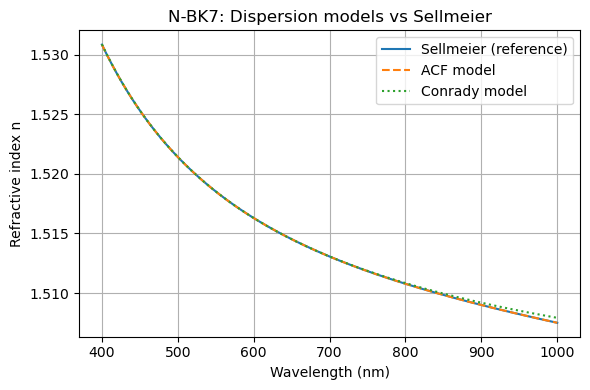

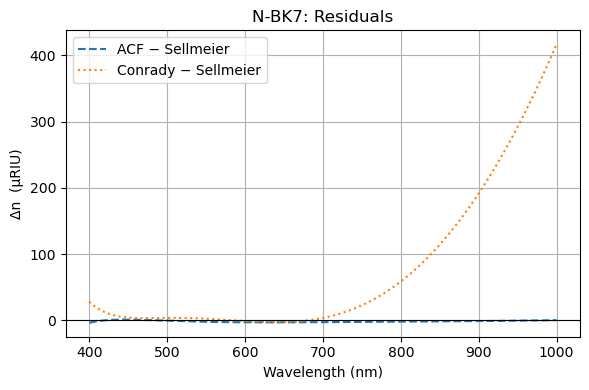

Lens radii: R1 = 50 mm, R2 = -50 mm
Focal‑shift impact for N-BK7 (λ ∈ [400,1000] nm):
  ACF       RMS Δf = 0.18 µm  (Δf/f RMS = 3.72e-06) | Max Δf = 0.32 µm  (Δf/f Max = 6.86e-06)
  Conrady   RMS Δf = 13.02 µm  (Δf/f RMS = 2.65e-04) | Max Δf = 40.46 µm  (Δf/f Max = 8.21e-04)


In [15]:
# Quick demo: N‑BK7, biconvex f≈100 mm (R=±50 mm)
plot_models("N-BK7", R1_mm=50, R2_mm=-50)

## From the Δn Residual Plot to Focal-Length Error  

The **second plot** in `plot_models()` shows  

* **x-axis:** wavelength $\lambda$ [nm]  
* **y-axis:** residual refractive-index error  
  $$\Delta n(\lambda)=n_{\text{model}}(\lambda)-n_{\text{Sell}}(\lambda)$$  
  multiplied by $10^{6}$ and reported in **µRIU** (micro-refractive-index units).

That tiny curve is exactly what drives the thin-lens focal-length shift.

---

### 1 Lens-maker equation (air on both sides)

$$
\frac{1}{f(\lambda)}=\bigl[n(\lambda)-1\bigr]
\Bigl(\frac{1}{R_1}-\frac{1}{R_2}\Bigr)
\;=\;\bigl[n(\lambda)-1\bigr]\,K,\qquad
K:=\frac{1}{R_1}-\frac{1}{R_2}.
$$

---

### 2 Design focal length with the catalog Sellmeier index  

$$
f_{\text{Sell}}(\lambda)=\frac{1}{\bigl[n_{\text{Sell}}(\lambda)-1\bigr]\,K}.
$$

---

### 3 Swap in a fitted model index  

Let $n_\ast(\lambda)=n_{\text{Sell}}(\lambda)+\Delta n(\lambda)$.  
Linearising for $\lvert\Delta n\rvert\!\ll\!1$ gives

$$
\frac{1}{f_\ast}=\bigl[n_\ast(\lambda)-1\bigr]K
                =\bigl[n_{\text{Sell}}(\lambda)-1\bigr]K
                 +\Delta n(\lambda)K
                =\frac{1}{f_{\text{Sell}}}+K\Delta n(\lambda).
$$

Solve for $f_\ast$

$$
f_\ast(\lambda)
   =\frac{1}
          {\displaystyle\frac{1}{f_{\text{Sell}}}+K\Delta n(\lambda)}
   =\frac{f_{\text{Sell}}}
          {1+K\,f_{\text{Sell}}\Delta n(\lambda)}.
$$

First‑order expansion $(|\Delta n|\!\ll1)$ gives

$$
f_\ast(\lambda)\approx
f_{\text{Sell}}(\lambda)\bigl[1-K\,f_{\text{Sell}}\Delta n(\lambda)\bigr].
$$

But $K\,f_{\text{Sell}}=1/\bigl[n_{\text{Sell}}(\lambda)-1\bigr]$, so

$$
\boxed{%
\Delta f(\lambda)=f_\ast-f_{\text{Sell}}
\approx
-\frac{f_{\text{Sell}}(\lambda)\,\Delta n(\lambda)}
       {\,n_{\text{Sell}}(\lambda)-1\,}}.
$$

---

### 4 Fractional focal-length error  

$$
\boxed{\;
\frac{\Delta f}{f}
\;\approx\;
-\frac{\Delta n}{\,n_{\text{Sell}}-1\,}}\!.
$$

---

### 5 Reading the second plot like a ruler  

For a typical crown glass $n_{\text{Sell}}\!\approx\!1.52 \;(\;n-1\!\approx\!0.52)$:  

| Peak height in the residual plot | $\Delta n$ | Resulting $\lvert\Delta f/f\rvert$ |
|----------------------------------|------------|-----------------------------------|
| 10 µRIU | $1\times10^{-5}$ | $1.9\times10^{-5}$ (0.0019 %) |
| 50 µRIU | $5\times10^{-5}$ | $9.6\times10^{-5}$ (0.0096 %) |
| 100 µRIU | $1\times10^{-4}$ | $1.9\times10^{-4}$ (0.019 %) |

Multiply the relative error by the nominal focal length to get the **absolute shift**.  
Example: a 100 mm lens with a 50 µRIU residual peak drifts by  

$$
\Delta f \approx 0.0096\% \times 100\,\text{mm} \approx 9.6\,\mu\text{m}.
$$

---

### 6 What the notebook prints  

`plot_models()` evaluates these formulas on a dense wavelength grid and reports  

